###Doves Classifier as an example of Transfer Learning & Fine-Tuning based on ImageNet.
[Source on Github](https://github.com/engma7moud3ly/doves-classifier)

Author: Mahmoud Aly - 22/5/2021
####Refrences
[Transfer learning and fine-tuning](https://www.tensorflow.org/tutorials/images/transfer_learning)


### import essential libraries

In [20]:
from bs4 import BeautifulSoup
import os
import json
from sys import argv
from tqdm import tqdm
import requests
import cv2
import shutil
from random import shuffle

import numpy as np
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

from IPython.display import Image
from IPython.display import clear_output as cls

import matplotlib.image as mpimg


###Dowload Doves Dataset

In [14]:
species=['collared','diamond','laughing','turtle','white']

In [15]:
def download(path, url):
    r = requests.get(url, stream=True)
    if r.status_code!=200:return
    with open(path, 'wb') as fd:
        for chunk in r.iter_content(1024*500):fd.write(chunk)

extract images links from yahoo search results

In [16]:
images={}
for s in species: 
  img_list = []
  src = open('search_results/%s.html'%s, "r", encoding="utf-8").read()
  html = BeautifulSoup(src, features="html.parser")
  imgs = html.findAll('img')
  for img in imgs:
    if img.has_attr('src'):
        image = img.attrs['src']
        image=image[0:image.find('&')]
        if image not in img_list:
            img_list.append(image)
  else:images[s]=img_list

download images to `doves` directory

In [8]:
!mkdir -p doves
for s in species:
  !mkdir -p "doves/$s"
img_shape=(224,224)
img_tail='&pid=Api&P=0&w=%s&h=%s'%(img_shape[0],img_shape[1])
for specie,img_list in tqdm(images.items()):
  print(specie)
  for i in range(len(img_list)):
    src=img_list[i]+img_tail
    dst='doves/%s/img%s.jpg'%(specie,i)
    download(dst,src)

  0%|          | 0/1 [00:00<?, ?it/s]

white


100%|██████████| 1/1 [01:00<00:00, 60.58s/it]


split images into train and test

In [9]:
!mkdir -p doves/train
!mkdir -p doves/test
for s in species:
  !mkdir -p "doves/train/$s"
  !mkdir -p "doves/test/$s"

for s in species:
  files=os.listdir('doves/'+s)
  shuffle(files)
  n=len(files)
  train_size=int(n*0.8)
  for f in files[0:train_size]:
    src='doves/%s/%s'%(s,f)
    dst='doves/train/%s/%s'%(s,f)
    shutil.move(src,dst)
  for f in files[train_size:]:
    src='doves/%s/%s'%(s,f)
    dst='doves/test/%s/%s'%(s,f)
    shutil.move(src,dst)

for s in species:
  !rm -r "doves/$s"    

###classification

this function reads the images in directory `doves` and split them to train,val,test




In [35]:
def read_ds(dir,val_size=0.2,shape=(224,224),batch_size=128):
        seed = 123
        test_ds = tf.keras.preprocessing.image_dataset_from_directory(
            dir+"/test",
            seed=seed,
            image_size=shape,
            batch_size=batch_size
        )
        train_ds = tf.keras.preprocessing.image_dataset_from_directory(
            dir+"/train",
            validation_split=val_size,
            subset="training",
            seed=seed,
            image_size=shape,
            batch_size=batch_size
        )

        val_ds = tf.keras.preprocessing.image_dataset_from_directory(
            dir+"/train",
            validation_split=val_size,
            subset="validation",
            seed=seed,
            image_size=shape,
            batch_size=batch_size
        )
        class_names = train_ds.class_names
        AUTOTUNE = tf.data.experimental.AUTOTUNE
        train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
        val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
        test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)
        return train_ds,val_ds,test_ds,class_names

read doves dataset

In [24]:
train_ds,val_ds,test_ds,class_names=read_ds('doves')
class_names

Found 606 files belonging to 5 classes.
Found 2415 files belonging to 5 classes.
Using 1932 files for training.
Found 2415 files belonging to 5 classes.
Using 483 files for validation.


['collared', 'diamond', 'laughing', 'turtle', 'white']

plot some samples

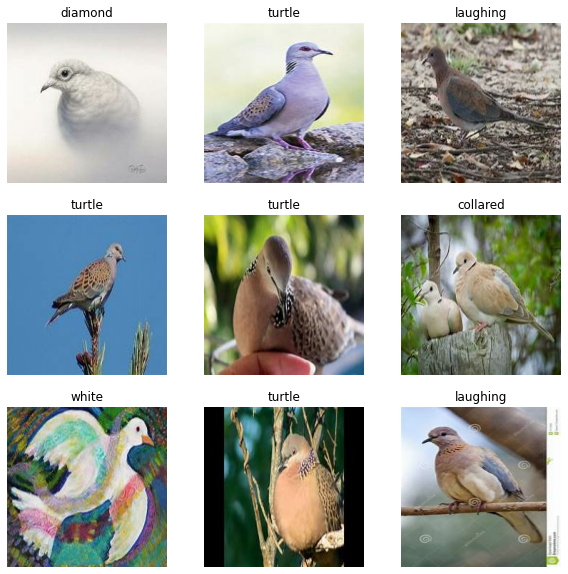

In [117]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

create a base model of the pre-trained network MobileNet

In [37]:
base_model = tf.keras.applications.MobileNetV2(input_shape=img_shape + (3,),include_top=False,weights='imagenet')
base_model.trainable = False

build a simple model based on MobileNet

In [42]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(len(class_names),activation='softmax')
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [43]:
inputs = tf.keras.Input(shape=img_shape+(3,))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

lest train our model on the `doves` images

In [44]:
initial_epochs=100
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/100
16/16 [==============================] - 6s 232ms/step - loss: 2.0831 - accuracy: 0.1998 - val_loss: 1.8269 - val_accuracy: 0.2029
Epoch 2/100
16/16 [==============================] - 3s 186ms/step - loss: 1.8699 - accuracy: 0.1998 - val_loss: 1.7292 - val_accuracy: 0.2381
Epoch 3/100
16/16 [==============================] - 3s 187ms/step - loss: 1.7655 - accuracy: 0.2349 - val_loss: 1.6591 - val_accuracy: 0.2650
Epoch 4/100
16/16 [==============================] - 3s 188ms/step - loss: 1.6999 - accuracy: 0.2666 - val_loss: 1.5949 - val_accuracy: 0.2899
Epoch 5/100
16/16 [==============================] - 3s 187ms/step - loss: 1.6333 - accuracy: 0.2974 - val_loss: 1.5350 - val_accuracy: 0.3333
Epoch 6/100
16/16 [==============================] - 3s 188ms/step - loss: 1.5596 - accuracy: 0.3329 - val_loss: 1.4813 - val_accuracy: 0.3665
Epoch 7/100
16/16 [==============================] - 3s 189ms/step - loss: 1.5193 - accuracy: 0.3584 - val_loss: 1.4344 - val_accuracy: 0.3934

In [46]:
model.evaluate(test_ds)

5/5 [==============================] - 2s 326ms/step - loss: 0.7667 - accuracy: 0.7310


[0.7667290568351746, 0.7310230731964111]

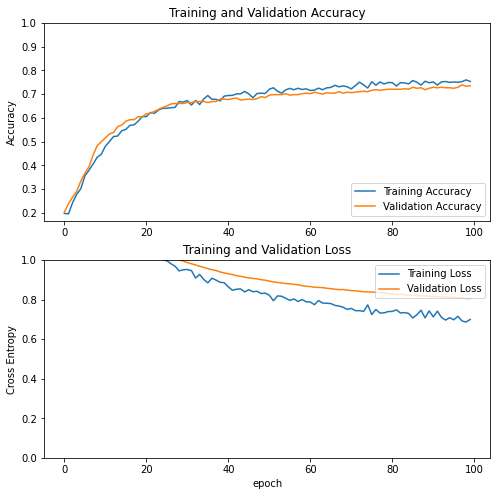

In [47]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Let's fine-tune the weights

In [48]:
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))
# Fine-tune from this layer onwards
fine_tune_at = 100
# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


compile the model again with lower learning rate

In [49]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.truediv_1 (TFOpLambd (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract_1 (TFOpLamb (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0   

In [53]:
fine_tune_epochs = 50
total_epochs =  initial_epochs + fine_tune_epochs
history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds)

Epoch 100/150
16/16 [==============================] - 4s 259ms/step - loss: 0.6665 - accuracy: 0.7774 - val_loss: 0.7766 - val_accuracy: 0.7557
Epoch 101/150
16/16 [==============================] - 4s 257ms/step - loss: 0.6451 - accuracy: 0.7790 - val_loss: 0.7705 - val_accuracy: 0.7474
Epoch 102/150
16/16 [==============================] - 4s 259ms/step - loss: 0.6509 - accuracy: 0.7702 - val_loss: 0.7633 - val_accuracy: 0.7371
Epoch 103/150
16/16 [==============================] - 4s 262ms/step - loss: 0.6161 - accuracy: 0.7774 - val_loss: 0.7410 - val_accuracy: 0.7536
Epoch 104/150
16/16 [==============================] - 4s 261ms/step - loss: 0.5955 - accuracy: 0.8023 - val_loss: 0.7399 - val_accuracy: 0.7598
Epoch 105/150
16/16 [==============================] - 4s 262ms/step - loss: 0.5808 - accuracy: 0.7992 - val_loss: 0.7278 - val_accuracy: 0.7598
Epoch 106/150
16/16 [==============================] - 4s 262ms/step - loss: 0.5700 - accuracy: 0.7997 - val_loss: 0.7172 - val_ac

In [54]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

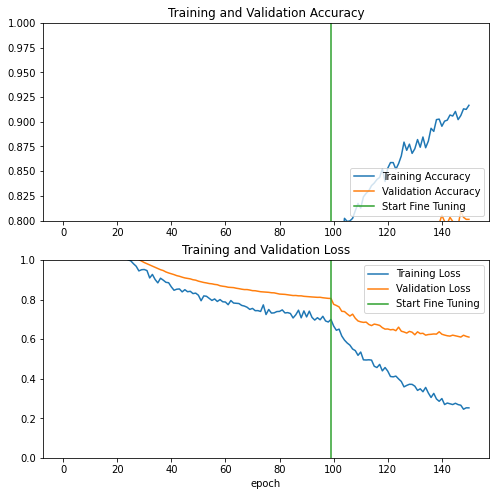

In [55]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

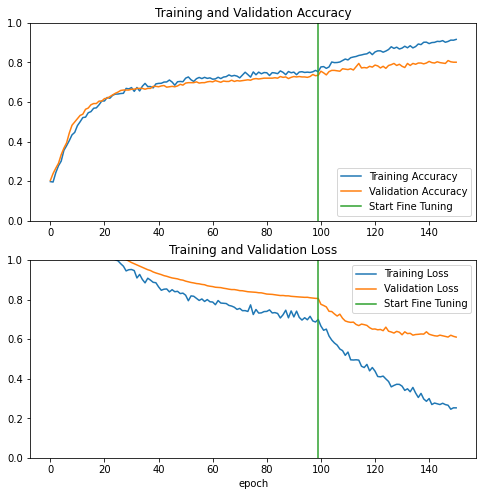

In [58]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [59]:
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)

5/5 [==============================] - 1s 142ms/step - loss: 0.6106 - accuracy: 0.8036
Test accuracy : 0.8036303520202637


Predictions:
 [4 0 0 2 4 0 0 2 3 4 1 0 3 0 1 1 1 1 2 0 3 0 4 3 0 4 4 1 0 4 2 0 0 0 2 2 1
 4 2 2 4 2 1 2 4 3 2 1 4 2 1 2 1 4 2 2 2 1 1 3 0 4 2 0 4 1 0 0 1 3 3 0 0 4
 4 4 1 0 3 4 4 0 3 2 0 3 4 4 1 4 1 2 4 4 4 1 4 1 3 4 4 0 0 0 2 4 1 1 4 4 4
 2 3 2 1 0 0 3 3 3 4 2 1 0 0 2 1 4]
Labels:
 [4 0 1 3 4 4 0 2 3 1 1 1 3 0 1 1 1 1 2 0 3 0 4 1 2 4 4 1 0 3 2 4 0 0 2 2 1
 4 2 2 4 2 1 2 4 3 2 1 4 2 1 2 1 4 2 2 3 1 3 0 0 4 2 0 3 1 0 0 1 1 3 0 0 4
 4 4 3 0 2 4 4 0 3 2 0 3 4 4 1 3 1 0 4 4 4 1 4 1 3 4 4 1 0 0 2 4 1 4 4 0 4
 2 3 2 1 0 0 3 3 3 4 0 1 0 0 3 1 4]


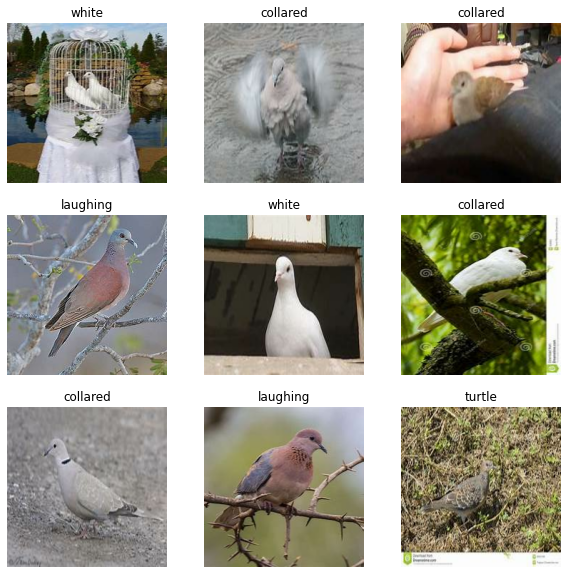

In [115]:
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).argmax(axis=1)

print('Predictions:\n', predictions)
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")